# Model Evaluation, Scoring Metrics, and Dealing with Imbalanced Classes

In the previous notebook, we already went into some detail on how to evaluate a model and how to pick the best model. So far, we assumed that we were given a performance measure, a measure  of the quality of the model. What measure one should use is not always obvious, though.
The default scores in scikit-learn are ``accuracy`` for classification, which is the fraction of correctly classified samples, and ``r2`` for regression, with is the coefficient of determination.

These are reasonable default choices in many scenarious; however, depending on our task, these are not always the definitive or recommended choices.

Let's take look at classification in more detail, going back to the application of classifying handwritten digits.
So, how about training a classifier and walking through the different ways we can evaluate it? Scikit-learn has many helpful methods in the ``sklearn.metrics`` module that can help us with this task:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=2)

In [2]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

digits = load_digits()
X, y = digits.data, digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=1,
                                                    stratify=y,
                                                    test_size=0.25)

classifier = LinearSVC(random_state=1).fit(X_train, y_train)
y_test_pred = classifier.predict(X_test)

print("Accuracy: {}".format(classifier.score(X_test, y_test)))

Accuracy: 0.9511111111111111


Here, we predicted 95.3% of samples correctly. For multi-class problems, it is often interesting to know which of the classes are hard to predict, and which are easy, or which classes get confused. One way to get more information about misclassifications is ``the confusion_matrix``, which shows for each true class, how frequent a given predicted outcome is.

In [3]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_test_pred)

array([[44,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0, 45,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  1, 43,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 45,  0,  0,  0,  0,  0,  1],
       [ 0,  2,  0,  0, 41,  0,  0,  1,  0,  1],
       [ 0,  1,  0,  0,  0, 42,  1,  0,  0,  2],
       [ 0,  0,  0,  0,  0,  1, 44,  0,  0,  0],
       [ 0,  1,  0,  0,  1,  0,  0, 42,  1,  0],
       [ 0,  4,  0,  1,  0,  0,  0,  0, 37,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 45]])

A plot is sometimes more readable:

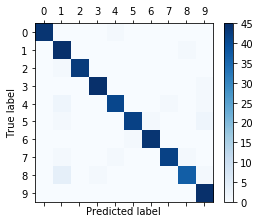

In [4]:
plt.matshow(confusion_matrix(y_test, y_test_pred), cmap="Blues")
plt.colorbar(shrink=0.8)
plt.xticks(range(10))
plt.yticks(range(10))
plt.xlabel("Predicted label")
plt.ylabel("True label");

We can see that most entries are on the diagonal, which means that we predicted nearly all samples correctly. The off-diagonal entries show us that many eights were classified as ones, and that nines are likely to be confused with many other classes. 

Another useful function is the ``classification_report`` which provides precision, recall, fscore and support for all classes.
Precision is how many of the predictions for a class are actually that class. With TP, FP, TN, FN standing for "true positive", "false positive", "true negative" and "false negative" repectively:

Precision = TP / (TP + FP)

Recall is how many of the true positives were recovered:

Recall = TP / (TP + FN)

F1-score is the geometric average of precision and recall:

F1 = 2 x (precision x recall) / (precision + recall)

The values of all these values above are in the closed interval [0, 1], where 1 means a perfect score.

In [5]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

             precision    recall  f1-score   support

          0       1.00      0.98      0.99        45
          1       0.83      0.98      0.90        46
          2       1.00      0.98      0.99        44
          3       0.98      0.98      0.98        46
          4       0.95      0.91      0.93        45
          5       0.98      0.91      0.94        46
          6       0.98      0.98      0.98        45
          7       0.98      0.93      0.95        45
          8       0.95      0.86      0.90        43
          9       0.90      1.00      0.95        45

avg / total       0.95      0.95      0.95       450



These metrics are helpful in two particular cases that come up often in practice:
1. Imbalanced classes, that is one class might be much more frequent than the other.
2. Asymmetric costs, that is one kind of error is much more "costly" than the other.

Let's have a look at 1. first. Say we have a class imbalance of 1:9, which is rather mild (think about ad-click-prediction where maybe 0.001% of ads might be clicked):

In [6]:
np.bincount(y) / y.shape[0]

array([ 0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1])

As a toy example, let's say we want to classify the digits three against all other digits:

In [7]:
X, y = digits.data, digits.target == 3

Now we run cross-validation on a classifier to see how well it does:

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

cross_val_score(SVC(), X, y)

array([ 0.9,  0.9,  0.9])

Our classifier is 90% accurate. Is that good? Or bad? Keep in mind that 90% of the data is "not three". So let's see how well a dummy classifier does, that always predicts the most frequent class:

In [9]:
from sklearn.dummy import DummyClassifier
cross_val_score(DummyClassifier("most_frequent"), X, y)

array([ 0.9,  0.9,  0.9])

Also 90% (as expected)! So one might thing that means our classifier is not very good, it doesn't to better than a simple strategy that doesn't even look at the data.
That would be judging too quickly, though. Accuracy is simply not a good way to evaluate classifiers for imbalanced datasets!

In [10]:
np.bincount(y) / y.shape[0]

array([ 0.9,  0.1])

ROC Curves
=======

A much better measure is using the so-called ROC (Receiver operating characteristics) curve. A roc-curve works with uncertainty outputs of a classifier, say the "decision_function" of the ``SVC`` we trained above. Instead of making a cut-off at zero and looking at classification outcomes, it looks at every possible cut-off and records how many true positive predictions there are, and how many false positive predictions there are.

The following plot compares the roc curve of three parameter settings of our classifier on the "three vs rest" task.

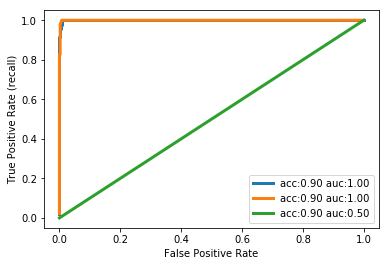

In [11]:
from sklearn.metrics import roc_curve, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

for gamma in [.01, .05, 1]:
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (recall)")
    svm = SVC(gamma=gamma).fit(X_train, y_train)
    decision_function = svm.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, decision_function)
    acc = svm.score(X_test, y_test)
    auc = roc_auc_score(y_test, svm.decision_function(X_test))
    plt.plot(fpr, tpr, label="acc:%.2f auc:%.2f" % (acc, auc), linewidth=3)
plt.legend(loc="best");

With a very small decision threshold, there will be few false positives, but also few false negatives, while with a very high threshold, both true positive rate and false positive rate will be high. So in general, the curve will be from the lower left to the upper right. A diagonal line reflects chance performance, while the goal is to be as much in the top left corner as possible. This means giving a higher decision_function value to all positive samples than to any negative sample.

In this sense, this curve only considers the ranking of the positive and negative samples, not the actual value.
As you can see from the curves and the accuracy values in the legend, even though all classifiers have the same accuracy, 89%, which is even lower than the dummy classifier, one of them has a perfect roc curve, while one of them performs on chance level.

For doing grid-search and cross-validation, we usually want to condense our model evaluation into a single number. A good way to do this with the roc curve is to use the area under the curve (AUC).
We can simply use this in ``cross_val_score`` by specifying ``scoring="roc_auc"``:

In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(SVC(), X, y, scoring="roc_auc")

array([ 1.,  1.,  1.])

Built-In and custom scoring functions
=======================================

There are many more scoring methods available, which are useful for different kinds of tasks. You can find them in the "SCORERS" dictionary. The only documentation explains all of them.

In [16]:
from sklearn.metrics.scorer import SCORERS
print(SCORERS.keys())

dict_keys(['r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'median_absolute_error', 'mean_absolute_error', 'mean_squared_error', 'accuracy', 'roc_auc', 'average_precision', 'log_loss', 'neg_log_loss', 'adjusted_rand_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])


It is also possible to define your own scoring metric. Instead of a string, you can provide a callable to as ``scoring`` parameter, that is an object with a ``__call__`` method or a function.
It needs to take a model, a test-set features ``X_test`` and test-set labels ``y_test``, and return a float. Higher floats are taken to mean better models.

Let's reimplement the standard accuracy score:

In [17]:
def my_accuracy_scoring(est, X, y):
    return np.mean(est.predict(X) == y)

cross_val_score(SVC(), X, y, scoring=my_accuracy_scoring)

array([ 0.9,  0.9,  0.9])

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>
      In previous sections, we typically used the accuracy measure to evaluate the performance of our classifiers. A related measure that we haven't talked about, yet, is the average-per-class accuracy (APCA). As we remember, the accuracy is defined as

$$ACC = \frac{TP+TN}{n},$$

where *n* is the total number of samples. This can be generalized to 

$$ACC =  \frac{T}{n},$$

where *T* is the number of all correct predictions in multi-class settings.
      </li>
    </ul>
    ![](figures/average-per-class.png)
    <li>
    Given the following arrays of "true" class labels and predicted class labels, can you implement a function that uses the accuracy measure to compute the average-per-class accuracy as shown below?
    </li>
</div>

In [18]:
y_true = np.array([0, 0, 0, 1, 1, 1, 1, 1, 2, 2])
y_pred = np.array([0, 1, 1, 0, 1, 1, 2, 2, 2, 2])

confusion_matrix(y_true, y_pred)

array([[1, 2, 0],
       [1, 2, 2],
       [0, 0, 2]])

In [20]:
# %load solutions/16A_avg_per_class_acc.py
def accuracy(true, pred):
    return (true == pred).sum() / float(true.shape[0])


def macro(true, pred):
    scores = []
    for l in np.unique(true):
        scores.append(accuracy(np.where(true != l, 1, 0),
                               np.where(pred != l, 1, 0)))
    return float(sum(scores)) / float(len(scores))

y_true = np.array([0, 0, 0, 1, 1, 1, 1, 1, 2, 2])
y_pred = np.array([0, 1, 1, 0, 1, 1, 2, 2, 2, 2])


print('accuracy:', accuracy(y_true, y_pred))
print('average-per-class accuracy:', macro(y_true, y_pred))


accuracy: 0.5
average-per-class accuracy: 0.6666666666666666
